In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys, re, time, math, multiprocessing, os
from numpy import array
from itertools import combinations, combinations_with_replacement, permutations, product
import numpy as np

In [3]:
def make_kmer_list(k, alphabet):
    """
    Generate kmer list.
    """
    if k < 0:
        print('Error, k must be an inter and larger than 0.')
    kmers = []
    for i in range(1, k + 1):
        if len(kmers) == 0:
            kmers = list(alphabet)
        else:
            new_kmers = []
            for kmer in kmers:
                for c in alphabet:
                    new_kmers.append(kmer + c)

            kmers = new_kmers

    return kmers



def frequency(tol_str, tar_str):
    """Generate the frequency of tar_str in tol_str.

    :param tol_str: mother string.
    :param tar_str: substring.
    """
    i, j, tar_count = (0, 0, 0)
    len_tol_str = len(tol_str)
    len_tar_str = len(tar_str)
    while i < len_tol_str and j < len_tar_str:
        if tol_str[i] == tar_str[j]:
            i += 1
            j += 1
            if j >= len_tar_str:
                tar_count += 1
                i = i - j + 1
                j = 0
        else:
            i = i - j + 1
            j = 0

    return tar_count

def _cmp(a, b):
    return (a > b) - (a < b)

def get_seq(filename, alphabet):
    seqs, cats = [], []
    for line in open(filename,'r'):
            seq, cat = line.split('\t')
            #seqs.append(seq.replace('T','U'))
            seqs.append(seq)
            cats.append(cat.replace('\n',''))
    return seqs

def get_label(filename, alphabet):
    seqs, cats = [], []
    for line in open(filename,'r'):
            seq, cat = line.split('\t')
            #seqs.append(seq.replace('T','U'))
            seqs.append(seq)
            cats.append(cat.replace('\n',''))
    return cats


def make_kmer_vector(k, alphabet, filename, revcomp=False):
    """Generate kmer vector."""
    seqs = get_seq(filename, alphabet=alphabet)
    if revcomp:
        if re.search('[^acgtACGT]', ''.join(alphabet)) is not None:
            sys.exit('Error, Only DNA sequence can be reverse compliment.')
    vector = []
    kmer_list = make_kmer_list(k, alphabet)
    for seq in seqs:
        count_sum = 0
        kmer_count = {}
        for kmer in kmer_list:
            temp_count = frequency(seq, kmer)
            if kmer not in kmer_count:
                kmer_count[kmer] = 0
            kmer_count[kmer] += temp_count
            count_sum += temp_count

        count_vec = [kmer_count[kmer] for kmer in kmer_list]
        #count_vec = [round(float(e) / count_sum, 8) for e in count_vec]
        count_vec = [round(float(e) / (len(seq)-k+1), 6) for e in count_vec]
        vector.append(count_vec)
    return vector




def get_fn(filename, alphabet):
    fns, cats = [], []
    for line in open(filename,'r'):
            seq, cat = line.split('\t')
            #fns.append(seq[0].replace('T','U'))
            fns.append(seq[0])
    return fns

def get_part(filename, alphabet):
    seqs, cats, WT, AGO = [], [], [], []
    for line in open(filename,'r'):
            seq, cat = line.split('\t')
            #seqs.append(seq[0].replace('T', 'U'))
            seqs.append(seq[0])
            cats.append(cat.replace('\n', ''))

    index1=[i for i, x in enumerate(cats) if x == "WT"]

    index2 = [i for i, x in enumerate(cats) if x != "WT"]

    for i in index1:
        WT.append(seqs[i])

    for i in index2:
        AGO.append(seqs[i])

    return WT, AGO

def make_first_vector(k, alphabet, filename, revcomp=False):
    """Generate kmer vector."""
    seqs = get_fn(filename, alphabet=alphabet)
    if revcomp:
        if re.search('[^acgtACGT]', ''.join(alphabet)) is not None:
            sys.exit('Error, Only DNA sequence can be reverse compliment.')
    vector = []
    kmer_list = make_kmer_list(k, alphabet)
    for seq in seqs:
        count_sum = 0
        kmer_count = {}
        for kmer in kmer_list:
            temp_count = frequency(seq, kmer)
            if not revcomp:
                if kmer not in kmer_count:
                    kmer_count[kmer] = 0
                kmer_count[kmer] += temp_count
            else:
                rev_kmer = find_revcomp(kmer, {})
                if kmer <= rev_kmer:
                    if kmer not in kmer_count:
                        kmer_count[kmer] = 0
                    kmer_count[kmer] += temp_count
                else:
                    if rev_kmer not in kmer_count:
                        kmer_count[rev_kmer] = 0
                    kmer_count[rev_kmer] += temp_count
            count_sum += temp_count

        if not revcomp:
            count_vec = [kmer_count[kmer] for kmer in kmer_list]
        else:
            revc_kmer_list = make_revcomp_kmer_list(kmer_list)
            count_vec = [kmer_count[kmer] for kmer in revc_kmer_list]
        vector.append(count_vec)
    return vector



In [4]:
RNA="ACGT"
data="./3_data_final/ERM_utr3_all.txt"
kmer=6

In [5]:
res = make_kmer_vector(k=kmer, alphabet=RNA, filename=data, revcomp=False)

In [6]:
cats = get_label(filename=data, alphabet=RNA)
for i in range(0, len(cats)):
    cats[i] = int(cats[i])

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#y_resampled_smote = le.fit_transform(cats)
X_array = np.array(res)

In [8]:
import pandas as pd
features = make_kmer_list(k=kmer, alphabet=RNA)
X = pd.DataFrame(res,columns=features)
y = np.array(cats)

In [9]:
from collections import Counter
print(sorted(Counter(y).items()))

[(0, 592), (1, 610)]


In [10]:
pos= np.count_nonzero(y == 1)
neg = np.count_nonzero(y == 0)
All=int(pos)+int(neg)
if int(neg-pos)>=0:
    Weight=float(neg/pos)
else:
    Weight=float(pos/neg)

In [11]:
from sklearn import model_selection
Train_X, Test_X, Train_y, Test_y = model_selection.train_test_split(X, y, stratify=y, test_size=0.2,random_state=2020)
#Train_X, Val_X, Train_y, Val_y = model_selection.train_test_split(Train_X, Train_y, stratify=Train_y, test_size=0.25,random_state=2020)


In [12]:
Train_X.shape

(961, 4096)

In [13]:
#from sklearn.svm import SVC
#from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [14]:
#rfc = RandomForestClassifier(random_state=2020, n_estimators=200, class_weight='balanced')
#Classifier = RandomForestClassifier(random_state=2020, n_estimators=200, class_weight='balanced')
Classifier = XGBClassifier(random_state=2020,n_estimators=100,eta=0.1, max_depth=6, eval_metric=['logloss','auc','error'],use_label_encoder=False, scale_pos_weight = float(Weight))

In [15]:
model=Classifier.fit(Train_X, Train_y)

In [16]:
print("Test mean accuracy: {0}".format(model.score(Test_X, Test_y)))
y_pred = model.predict(Test_X)
print(classification_report(Test_y, y_pred))

Test mean accuracy: 0.8547717842323651
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       119
           1       0.89      0.81      0.85       122

    accuracy                           0.85       241
   macro avg       0.86      0.86      0.85       241
weighted avg       0.86      0.85      0.85       241



In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [18]:
cv = StratifiedKFold(n_splits=5)  # 导入该模型，后面将数据划分5份

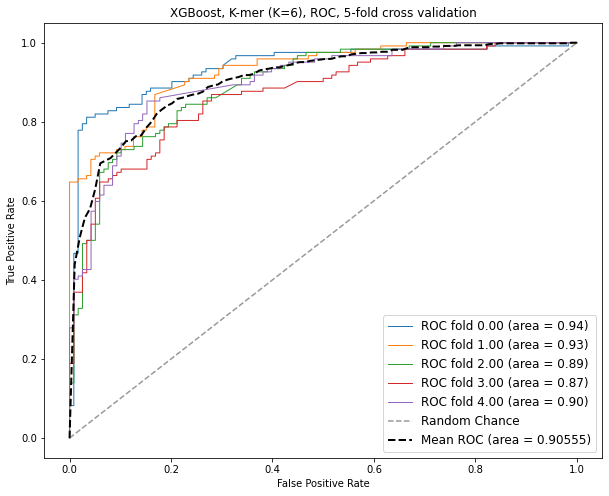

In [19]:
plt.figure(figsize=(10, 8))
# 画平均ROC曲线的两个参数
mean_tpr = 0.0  # 用来记录画平均ROC曲线的信息
mean_fpr = np.linspace(0, 1, 100)
cnt = 0
for i, (train, test) in enumerate(cv.split(X_array, y)):  # 利用模型划分数据集和目标变量 为一一对应的下标
    cnt += 1
    y_score = Classifier.fit(X_array[train], y[train]).predict_proba(X_array[test])  # 训练模型后预测每条样本得到两种结果的概率
    fpr, tpr, thresholds = roc_curve(y[test], y_score[:, 1])  # 该函数得到伪正例、真正例、阈值，这里只使用前两个

    mean_tpr += np.interp(mean_fpr, fpr, tpr)  # 插值函数 interp(x坐标,每次x增加距离,y坐标)  累计每次循环的总值后面求平均值
    mean_tpr[0] = 0.0  # 将第一个真正例=0 以0为起点

    roc_auc = auc(fpr, tpr)  # 求auc面积
    
    plt.plot(fpr, tpr, lw=1, label='ROC fold {0:.2f} (area = {1:.2f})'.format(i, roc_auc))  # 画出当前分割数据的ROC曲线
    #plt.plot(fpr, tpr, lw=1)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Chance')  # 画对角线

mean_tpr /= cnt  # 求数组的平均值
mean_tpr[-1] = 1.0  # 坐标最后一个点为（1,1）  以1为终点
mean_auc = auc(mean_fpr, mean_tpr)



plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = {0:.5f})'.format(mean_auc), lw=2)

plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，设置宽一点，以免和边缘重合，可以更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('XGBoost, K-mer (K=6), ROC, 5-fold cross validation')
plt.legend(loc="lower right", prop={'size': 12})

plt.show()


<Figure size 842.4x595.44 with 0 Axes>

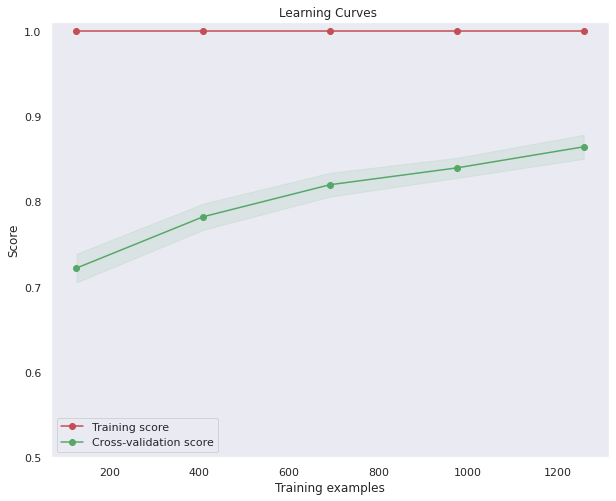

In [69]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=5, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.figure(figsize=(10, 8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower left") #best
    return plt


from sklearn.model_selection import ShuffleSplit

title = "Learning Curves " #(SVM, RBF kernel, $\gamma=0.001$)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=2020)
#estimator = RandomForestClassifier(silent=True)  # 建模

plot_learning_curve(Classifier, title, X_resampled_smote, y_resampled_smote, (0.5, 1.01), cv=cv, n_jobs=5)
#plt.savefig('lc1.png')
plt.show()

In [25]:
import shap

In [26]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


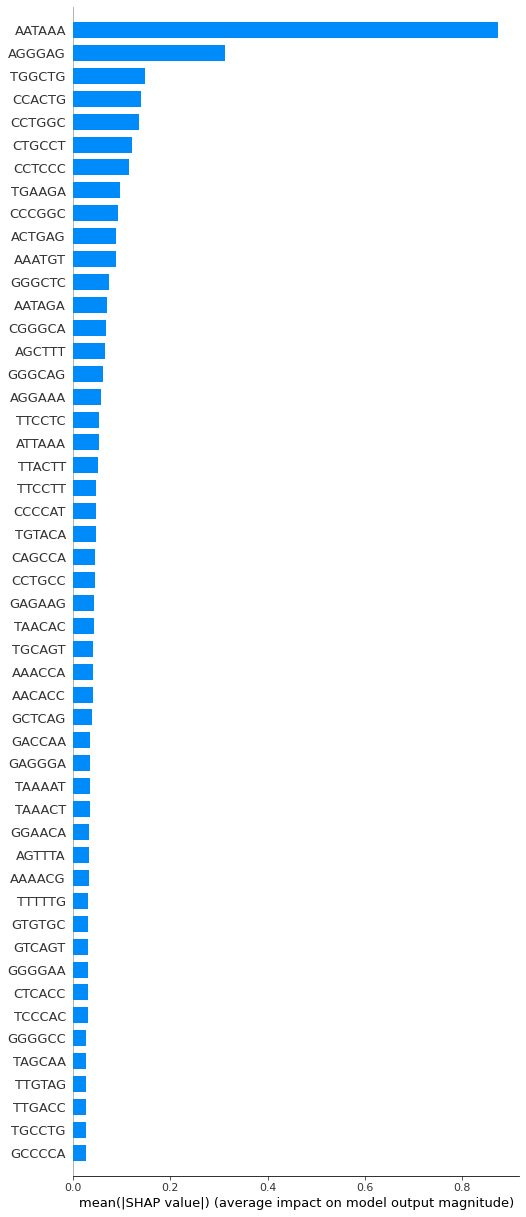

In [27]:
shap.summary_plot(shap_values, X, plot_type="bar", max_display=50)

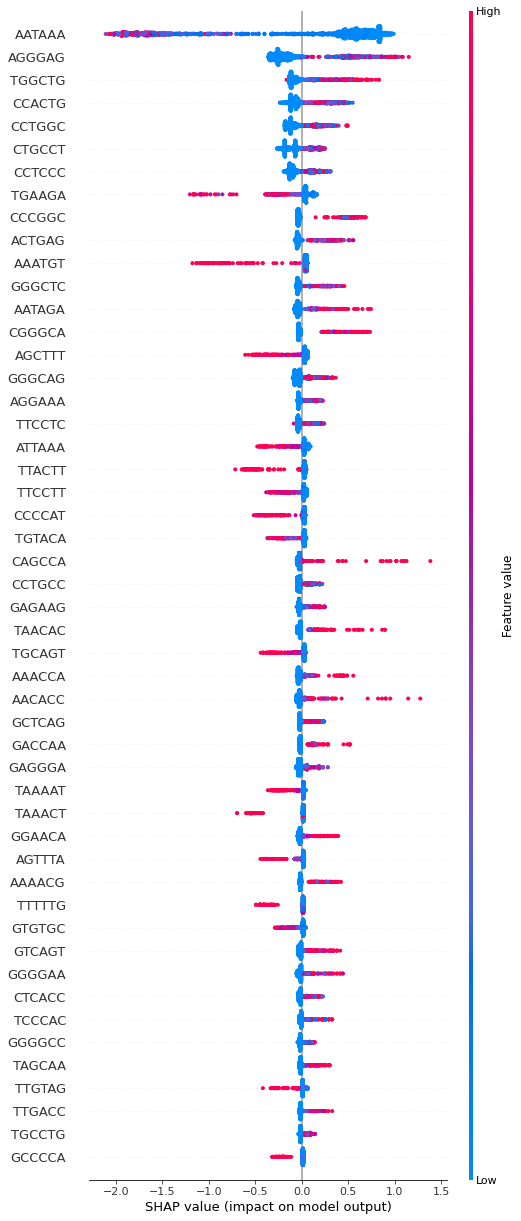

In [23]:
shap.summary_plot(shap_values, X, max_display=50)

In [24]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns
feature_importance['importance'] = np.abs(shap_values).mean(0)
feature_importance.sort_values('importance', ascending=False)

,feature,importance
192,AATAAA,0.874078
674,AGGGAG,0.312799
3742,TGGCTG,0.149060
1310,CCACTG,0.139649
1513,CCTGGC,0.135100
...,...,...
1614,CGCATG,0.000000
1615,CGCATT,0.000000
1616,CGCCAA,0.000000
1618,CGCCAG,0.000000


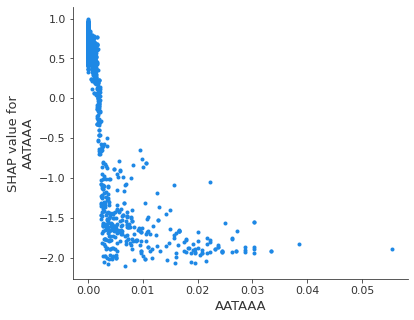

In [29]:
shap.dependence_plot('AATAAA', shap_values, X, interaction_index=None)

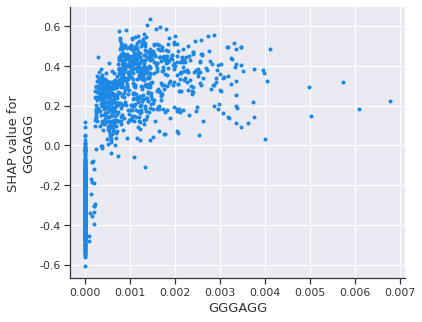

In [70]:
shap.dependence_plot('GGGAGG', shap_values, X, interaction_index=None)

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
#设置绘图风格
plt.style.use('ggplot')
#处理中文乱码
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
#坐标轴负号的处理
plt.rcParams['axes.unicode_minus']=False
# 读取数据
tips=pd.read_table('./4_data_pos_all/ERM_len.txt',sep='\t')

In [64]:
tips

,utr3,type,name
0,1115,pos,ERM
1,2452,pos,ERM
2,979,pos,ERM
3,1210,pos,ERM
4,576,pos,ERM
...,...,...,...
3083,3,neg,G3BP1_A
3084,3,neg,G3BP1_A
3085,677,neg,G3BP1_A
3086,517,neg,G3BP1_A


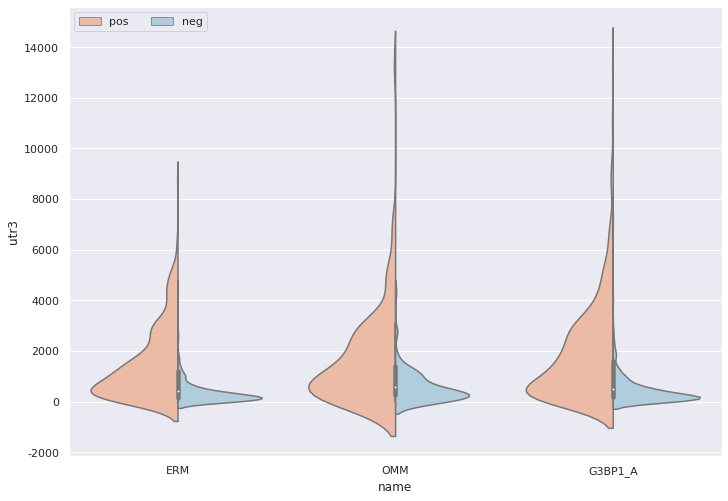

In [66]:
# 绘制分组小提琴图
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.violinplot(x = "name", # 指定x轴的数据
               y = "utr3", # 指定y轴的数据
               hue = "type", # 指定分组变量
               data = tips, # 指定绘图的数据集
               #order = ['Thur','Fri','Sat','Sun'], # 指定x轴刻度标签的顺序
               scale = 'count', # 以男女客户数调节小提琴图左右的宽度
               split = True, # 将小提琴图从中间割裂开，形成不同的密度曲线；
               palette = 'RdBu' # 指定不同性别对应的颜色（因为hue参数为设置为性别变量）
              )
# 添加图形标题
#plt.title('每天不同性别客户的酒吧消费额情况')
# 设置图例
plt.legend(loc = 'upper left', ncol = 2)
# 显示图形
plt.show()